<a href="https://colab.research.google.com/github/aditya2482/AnimeRecommenderRBM/blob/main/Kaggle_conn_AnimeReccomender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityakumarcat","key":"ffd51c227be88b884ce8a86708670500"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-01 17:39:01          13101  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           7912  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3452  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           3048  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [9]:
! kaggle datasets download -d kanametov/movies-recomendation-system

 93% 145M/155M [00:03<00:00, 37.5MB/s]
100% 155M/155M [00:03<00:00, 48.2MB/s]


In [10]:
! unzip /content/movies-recomendation-system.zip

Archive:  /content/movies-recomendation-system.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [12]:
d1=pd.read_csv("/content/movies.csv")
d2=pd.read_csv("/content/ratings.csv")
d1=d1.drop("title",axis=1).drop("genres",axis=1)
d1['movieIndex']=d1.index
d1.head()

,movieId,movieIndex
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [13]:

data = d1.merge(d2,on = 'movieId',how ='left')
movie_list=data.movieId.unique()
data = data.fillna(0)


data['rating'] = data['rating'].astype(int)
data['userId'] = data['userId'].astype(int)
data['userId'].isnull().values.any()

False

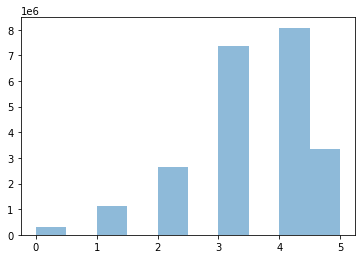

In [14]:
plt.hist(data.rating,alpha = 0.5)

plt.show()

In [22]:
data = data[data['rating'] > 2]
data = data[data['userId'] > 200000]
data = data.drop('timestamp',axis = 1)

<function matplotlib.pyplot.show>

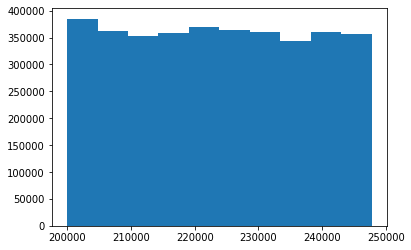

In [16]:
plt.hist(data.userId,alpha = 1.0)
plt.show

In [17]:
data.head()
print(data[data['rating'] == 0])

Empty DataFrame
Columns: [movieId, movieIndex, userId, rating, timestamp]
Index: []


In [18]:
data.isnull().sum()

movieId       0
movieIndex    0
userId        0
rating        0
timestamp     0
dtype: int64

In [23]:
data_g=data.groupby('userId')
data_g.first().head()

,movieId,movieIndex,rating
userId,,,
200001,10,9,3
200002,260,257,3
200003,82,81,5
200004,616,610,4
200005,123,121,5


In [24]:
"""
Formatting input / Training data
Storing normalised user rating into a list[list[data]]
known as trx
"""
# normalizing data
maxRating = data_g.rating.max()
# maxrating = 5
amtofusertrain = 100
trx=[]

for userId,curUser in data_g:
    temp = [0]*len(movie_list)
    for num,movie in curUser.iterrows():
        temp[movie['movieIndex']] = movie.rating/maxRating
    trx.append(temp)
    if amtofusertrain == 0:
        break
    amtofusertrain -= 1


In [25]:
print(trx[0][2]) # Holds the input values

0


In [36]:
# setting up models param - 1) visible units
#                            2) hidden units
#                             3)weights 

hiddenunits = 25
visibleunits = len(movie_list) # unique movies

vb =  tf.placeholder("float",[visibleunits])
hb = tf.placeholder("float",[hiddenunits])
W = tf.placeholder("float",[visibleunits,hiddenunits])


In [34]:
print(len(movie_list))

34208


In [37]:
# setting up Input processing p-1
v0 = tf.placeholder("float",[None,visibleunits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))


In [38]:
# p-2 reconstruction phase
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)  # Hidden layer activation
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [39]:
""" Set RBM Training Parameters """

# Learning rate
alpha = 1.0

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

Instructions for updating:
Use `tf.cast` instead.


In [42]:
# Current weight
cur_w = np.zeros([visibleunits, hiddenunits], np.float32)

# Current visible unit biases
cur_vb = np.zeros([visibleunits], np.float32)

# Current hidden unit biases
cur_hb = np.zeros([hiddenunits], np.float32)

# Previous weight
prv_w = np.zeros([visibleunits, hiddenunits], np.float32)

# Previous visible unit biases
prv_vb = np.zeros([visibleunits], np.float32)

# Previous hidden unit biases
prv_hb = np.zeros([hiddenunits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [52]:
epochs = 15
batchsize = 50
errors = []

for i in range(epochs):
    for start, end in zip(range(0, len(trx), batchsize), range(batchsize, len(trx), batchsize)):
        batch = trx[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

ValueError: ignored

In [ ]:
"""
Recommendation System :-
- We can now predict anime that an arbitrarily selected user might like. 
- This can be accomplished by feeding in the user's watched preferences into the RBM and then reconstructing the 
  input. 
- The values that the RBM gives us will attempt to estimate the user's preferences for items that he hasn't watched 
  based on the preferences of the users that the RBM was trained on.
"""

# Select the example User
inputUser = [trX[50]]

In [ ]:
# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
recommendation = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [ ]:
# List the 20 most recommended items for our mock user by sorting it by their scores given by our model.
recos_for_user = anime_data
recos_for_user["Recommendation Score"] = recommendation[0]
recos_for_user.sort_values(["Recommendation Score"], ascending=False).head(20)